# Session 4 — Paragraph-Level Analysis
## Measure 1: Paragraph Semantic Coherence

In this notebook, you will:
- split your text into paragraphs and sentences
- compute **embedding-based coherence** per paragraph using MiniLM
- compare coherence distributions across two books
- connect this to how RAG systems and LLMs assess chunk quality

We again use Lewis Carroll's *Alice* books as examples. Replace the file
paths with your own author/text for your project.


In [90]:
import re
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import gc

# You may need to install this once in your environment:
# pip install sentence-transformers
from sentence_transformers import SentenceTransformer

# Create results directory
Path("../results").mkdir(exist_ok=True)
print("✓ Results directory created/verified")

# Load the MiniLM embedding model
# This model converts text into numerical vectors (embeddings)
# that capture semantic meaning
print("Loading embedding model (this may take a moment)...")
model = SentenceTransformer('all-MiniLM-L6-v2')
print("✓ Model loaded successfully")

def load_book(filepath: str) -> str:
    """
    Load and lightly clean a book text (Project Gutenberg style).

    Removes headers and footers to get clean text for analysis.

    Args:
        filepath: path to the text file

    Returns:
        Cleaned text as string
    """
    with open(filepath, 'r', encoding='utf-8') as f:
        text = f.read()

    # Simple Project Gutenberg cleaner
    # Look for common start markers
    if 'BOOK I' in text:
        start = text.find('BOOK I')
        text = text[start:]
    elif 'CHAPTER I' in text:
        start = text.find('CHAPTER I')
        text = text[start:]
    elif '*** START OF' in text:
        start = text.find('*** START OF')
        text = text[start + 100:]

    # Look for common end markers
    if '*** END OF' in text:
        end = text.find('*** END OF')
        text = text[:end]
    elif 'End of Project Gutenberg' in text:
        end = text.find('End of Project Gutenberg')
        text = text[:end]

    return text.strip()

# Load both Homer epics
print("\nLoading texts...")
iliad_text = load_book('../data/iliad.txt')
odyssey_text = load_book('../data/odyssey.txt')

print(f"✓ The Iliad: {len(iliad_text):,} characters")
print(f"✓ The Odyssey: {len(odyssey_text):,} characters")

✓ Results directory created/verified
Loading embedding model (this may take a moment)...
✓ Model loaded successfully

Loading texts...
✓ The Iliad: 806,631 characters
✓ The Odyssey: 609,700 characters


In [91]:
def split_into_paragraphs(text: str, min_words: int = 10) -> List[str]:
    """
    Split raw text into paragraphs using blank lines as boundaries.

    In books, paragraphs are separated by blank lines (double newlines).
    We filter out very short paragraphs like chapter titles.

    Args:
        text: the complete text
        min_words: minimum words required to count as a paragraph

    Returns:
        List of paragraph strings
    """
    # Normalize line endings
    text = text.replace('\r\n', '\n').replace('\r', '\n')

    # Split on blank lines (one or more empty lines)
    raw_paras = re.split(r'\n\s*\n+', text)

    paras = []
    for p in raw_paras:
        # Clean up whitespace
        cleaned = re.sub(r'\s+', ' ', p).strip()
        if not cleaned:
            continue
        # Filter out short paragraphs (likely titles or artifacts)
        if len(cleaned.split()) < min_words:
            continue
        paras.append(cleaned)

    return paras

def sentence_split(paragraph: str) -> List[str]:
    """
    Simple sentence splitter based on punctuation.

    Splits on periods, exclamation marks, and question marks.

    Args:
        paragraph: text to split

    Returns:
        List of sentences
    """
    sentences = re.split(r'[.!?]+\s+', paragraph.strip())
    sentences = [s.strip() for s in sentences if s.strip()]
    return sentences

def cosine_similarity(a: np.ndarray, b: np.ndarray) -> float:
    """
    Calculate cosine similarity between two vectors.

    Cosine similarity measures how similar two vectors are:
    - 1.0 = identical direction (very similar)
    - 0.0 = perpendicular (unrelated)
    - -1.0 = opposite direction (very dissimilar)

    Args:
        a, b: embedding vectors

    Returns:
        Similarity score between 0 and 1
    """
    if a.ndim > 1:
        a = a.reshape(-1)
    if b.ndim > 1:
        b = b.reshape(-1)
    denom = (np.linalg.norm(a) * np.linalg.norm(b))
    if denom == 0:
        return 0.0
    return float(np.dot(a, b) / denom)

def paragraph_coherence_embeddings(paragraphs: List[str]) -> Tuple[list, list]:
    """
    Compute embedding-based coherence for each paragraph.
    Uses pairwise sentence similarities.
    """
    scores = []
    lengths = []

    print(f"Analyzing {len(paragraphs)} paragraphs...")

    for i, p in enumerate(paragraphs):
        if (i + 1) % 100 == 0:
            print(f"  Processed {i + 1}/{len(paragraphs)} paragraphs...")

        sents = sentence_split(p)
        if len(sents) < 2:
            continue

        # Encode sentences - CRITICAL: normalize_embeddings=True
        sent_embs = model.encode(sents, normalize_embeddings=True, convert_to_numpy=True)

        # Ensure embeddings are 2D (n_sentences, embedding_dim)
        if sent_embs.ndim == 1:
            sent_embs = sent_embs.reshape(1, -1)

        # Calculate pairwise cosine similarities manually (more reliable than sklearn here)
        n_sents = len(sent_embs)
        pairwise_sims = []

        for j in range(n_sents):
            for k in range(j + 1, n_sents):
                # Manual cosine similarity (already normalized, so just dot product)
                sim = np.dot(sent_embs[j], sent_embs[k])
                pairwise_sims.append(float(sim))

        # Average of all pairwise similarities
        if pairwise_sims:
            coherence = np.mean(pairwise_sims)
        else:
            coherence = 0.0

        scores.append(coherence)
        lengths.append(len(" ".join(sents).split()))

    print(f"✓ Analysis complete")
    return scores, lengths
# Split texts into paragraphs
print("\nSplitting texts into paragraphs...")
iliad_paras = split_into_paragraphs(iliad_text)
odyssey_paras = split_into_paragraphs(odyssey_text)

print(f"✓ The Iliad: {len(iliad_paras)} paragraphs")
print(f"✓ The Odyssey: {len(odyssey_paras)} paragraphs")

# Calculate coherence scores for each paragraph
print("\nCalculating coherence scores for The Iliad...")
iliad_scores, iliad_lengths = paragraph_coherence_embeddings(iliad_paras)

print("\nCalculating coherence scores for The Odyssey...")
odyssey_scores, odyssey_lengths = paragraph_coherence_embeddings(odyssey_paras)

# Print summary statistics
print("\n" + "="*70)
print("COHERENCE SUMMARY")
print("="*70)
print(f"The Iliad mean coherence: {sum(iliad_scores)/len(iliad_scores):.3f}")
print(f"The Odyssey mean coherence: {sum(odyssey_scores)/len(odyssey_scores):.3f}")
print(f"\nInterpretation:")
print(f"  Higher score = paragraphs stick to one topic")
print(f"  Lower score = paragraphs cover multiple topics")



Splitting texts into paragraphs...
✓ The Iliad: 1113 paragraphs
✓ The Odyssey: 1026 paragraphs

Calculating coherence scores for The Iliad...
Analyzing 1113 paragraphs...
  Processed 100/1113 paragraphs...
  Processed 200/1113 paragraphs...
  Processed 300/1113 paragraphs...
  Processed 400/1113 paragraphs...
  Processed 500/1113 paragraphs...
  Processed 600/1113 paragraphs...
  Processed 700/1113 paragraphs...
  Processed 800/1113 paragraphs...
  Processed 900/1113 paragraphs...
  Processed 1000/1113 paragraphs...
  Processed 1100/1113 paragraphs...
✓ Analysis complete

Calculating coherence scores for The Odyssey...
Analyzing 1026 paragraphs...
  Processed 100/1026 paragraphs...
  Processed 200/1026 paragraphs...
  Processed 300/1026 paragraphs...
  Processed 400/1026 paragraphs...
  Processed 500/1026 paragraphs...
  Processed 600/1026 paragraphs...
  Processed 700/1026 paragraphs...
  Processed 800/1026 paragraphs...
  Processed 900/1026 paragraphs...
  Processed 1000/1026 paragr


✓ Saved: ../results/paragraph_coherence_vs_length.png


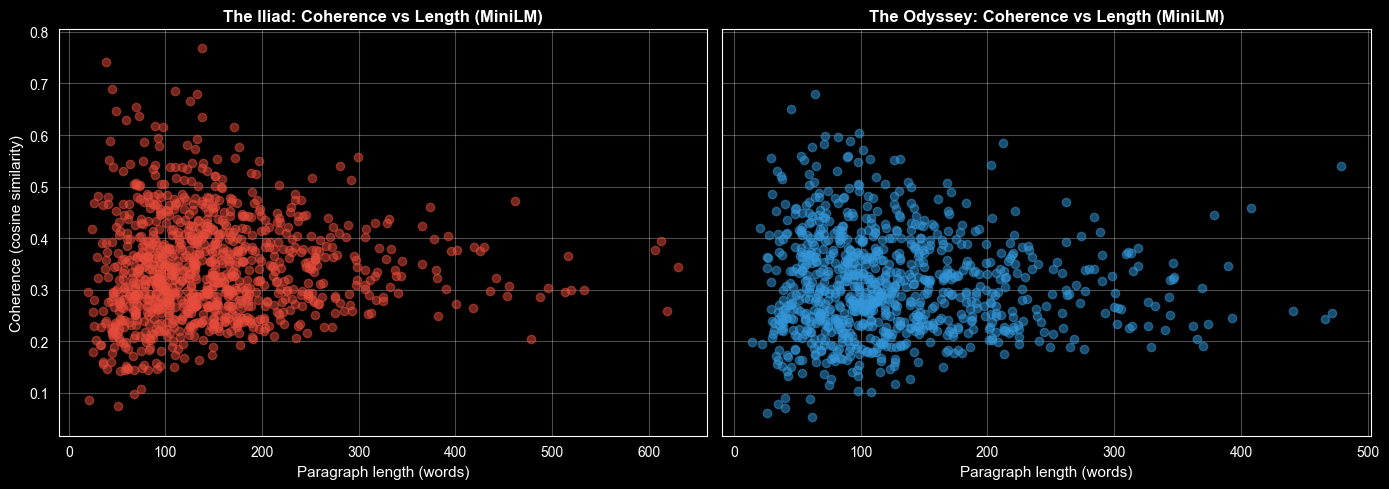

In [92]:
# Create scatter plots showing relationship between length and coherence
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# The Iliad
axes[0].scatter(iliad_lengths, iliad_scores, alpha=0.5, color='#e74c3c')
axes[0].set_title("The Iliad: Coherence vs Length (MiniLM)",
                  fontsize=12, fontweight='bold')
axes[0].set_xlabel("Paragraph length (words)", fontsize=11)
axes[0].set_ylabel("Coherence (cosine similarity)", fontsize=11)
axes[0].grid(True, alpha=0.3)

# The Odyssey
axes[1].scatter(odyssey_lengths, odyssey_scores, alpha=0.5, color='#3498db')
axes[1].set_title("The Odyssey: Coherence vs Length (MiniLM)",
                  fontsize=12, fontweight='bold')
axes[1].set_xlabel("Paragraph length (words)", fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("../results/paragraph_coherence_vs_length.png", dpi=300, bbox_inches='tight')
print("\n✓ Saved: ../results/paragraph_coherence_vs_length.png")
plt.show()

✓ Saved: ../results/paragraph_coherence_distribution.png


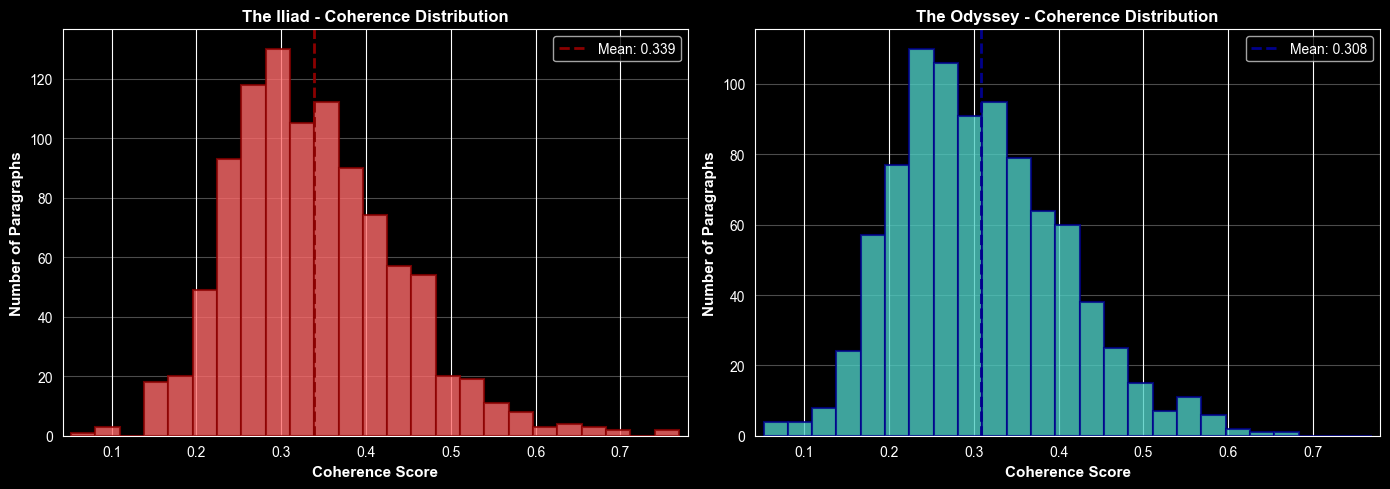

In [100]:
# Create side-by-side histograms for clearer comparison
# Set same x-axis range for fair comparison
all_scores = iliad_scores + odyssey_scores
min_score = min(all_scores)
max_score = max(all_scores)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# The Iliad histogram
axes[0].hist(iliad_scores, bins=25, alpha=0.8,
             edgecolor='darkred', linewidth=1.5, color='#ff6b6b',
             range=(min_score, max_score))
axes[0].axvline(np.mean(iliad_scores), color='darkred',
                linestyle='--', linewidth=2, label=f'Mean: {np.mean(iliad_scores):.3f}')
axes[0].set_xlabel('Coherence Score', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Paragraphs', fontsize=11, fontweight='bold')
axes[0].set_title('The Iliad - Coherence Distribution',
                  fontsize=12, fontweight='bold')
axes[0].set_xlim(min_score - 0.01, max_score + 0.01)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# The Odyssey histogram
axes[1].hist(odyssey_scores, bins=25, alpha=0.8,
             edgecolor='darkblue', linewidth=1.5, color='#4ecdc4',
             range=(min_score, max_score))
axes[1].axvline(np.mean(odyssey_scores), color='darkblue',
                linestyle='--', linewidth=2, label=f'Mean: {np.mean(odyssey_scores):.3f}')
axes[1].set_xlabel('Coherence Score', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Number of Paragraphs', fontsize=11, fontweight='bold')
axes[1].set_title('The Odyssey - Coherence Distribution',
                  fontsize=12, fontweight='bold')
axes[1].set_xlim(min_score - 0.01, max_score + 0.01)
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig("../results/paragraph_coherence_distribution.png", dpi=300, bbox_inches='tight')
print("✓ Saved: ../results/paragraph_coherence_distribution.png")
plt.show()

In [94]:
print("\n" + "="*70)
print("DETAILED STATISTICS")
print("="*70)
print(f"\nThe Iliad:")
print(f"  Paragraphs analyzed: {len(iliad_scores)}")
print(f"  Mean coherence: {np.mean(iliad_scores):.3f}")
print(f"  Std deviation: {np.std(iliad_scores):.3f}")
print(f"  Min coherence: {np.min(iliad_scores):.3f}")
print(f"  Max coherence: {np.max(iliad_scores):.3f}")

print(f"\nThe Odyssey:")
print(f"  Paragraphs analyzed: {len(odyssey_scores)}")
print(f"  Mean coherence: {np.mean(odyssey_scores):.3f}")
print(f"  Std deviation: {np.std(odyssey_scores):.3f}")
print(f"  Min coherence: {np.min(odyssey_scores):.3f}")
print(f"  Max coherence: {np.max(odyssey_scores):.3f}")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("What these scores mean:")
print("- Coherence measures how semantically unified each paragraph is")
print("- Higher scores = sentences within paragraph are about the same topic")
print("- Lower scores = sentences cover diverse topics within same paragraph")
print("- This is relevant for RAG systems: coherent chunks improve retrieval")
print("- Epic poetry may have lower coherence due to descriptive digressions")

print("\n" + "="*70)
print("EXPORT SUMMARY")
print("="*70)
print("All visualizations have been saved to ../results/:")
print("  1. paragraph_coherence_vs_length.png - Scatter plots")
print("  2. paragraph_coherence_distribution.png - Histogram comparison")
print("  3. paragraph_topic_clustering.png - Topic diversity pie charts")
print("  4. paragraph_3d_analysis.png - 3D visualization")
print("  5. book_similarity_heatmaps.png - Semantic similarity between books")
print("  6. paragraph_importance_analysis.png - Most important paragraphs")
print("✓ Analysis complete!")


DETAILED STATISTICS

The Iliad:
  Paragraphs analyzed: 996
  Mean coherence: 0.339
  Std deviation: 0.099
  Min coherence: 0.074
  Max coherence: 0.769

The Odyssey:
  Paragraphs analyzed: 885
  Mean coherence: 0.308
  Std deviation: 0.098
  Min coherence: 0.052
  Max coherence: 0.680

INTERPRETATION
What these scores mean:
- Coherence measures how semantically unified each paragraph is
- Higher scores = sentences within paragraph are about the same topic
- Lower scores = sentences cover diverse topics within same paragraph
- This is relevant for RAG systems: coherent chunks improve retrieval
- Epic poetry may have lower coherence due to descriptive digressions

EXPORT SUMMARY
All visualizations have been saved to ../results/:
  1. paragraph_coherence_vs_length.png - Scatter plots
  2. paragraph_coherence_distribution.png - Histogram comparison
  3. paragraph_topic_clustering.png - Topic diversity pie charts
  4. paragraph_3d_analysis.png - 3D visualization
  5. book_similarity_heatma


TOPIC DIVERSITY ANALYSIS

Analyzing The Iliad...
Clustering 1113 paragraphs into 5 topics...


Batches: 100%|██████████| 35/35 [00:03<00:00, 10.16it/s]


✓ Clustering complete

Analyzing The Odyssey...
Clustering 1026 paragraphs into 5 topics...


Batches: 100%|██████████| 33/33 [00:02<00:00, 13.03it/s]


✓ Clustering complete

TOPIC INSPECTION - Sample paragraphs from each cluster

--- THE ILIAD TOPICS ---

TOPIC 1 (248 paragraphs, 22.3%)
Sample: And which of the gods was it that set them on to quarrel? It was the son of Jove and Leto; for he was angry with the king and sent a pestilence upon the host to plague the people, because the son of Atreus had dishonoured Chryses his priest. Now Chryses had come to the ships of the Achaeans to free ...


TOPIC 2 (146 paragraphs, 13.1%)
Sample: Sing, O goddess, the anger of Achilles son of Peleus, that brought countless ills upon the Achaeans. Many a brave soul did it send hurrying down to Hades, and many a hero did it yield a prey to dogs and vultures, for so were the counsels of Jove fulfilled from the day on which the son of Atreus, kin...


TOPIC 3 (222 paragraphs, 19.9%)
Sample: Thus she spoke, but Hector knew that it was the goddess, and at once broke up the assembly. The men flew to arms; all the gates were opened, and the people thronge

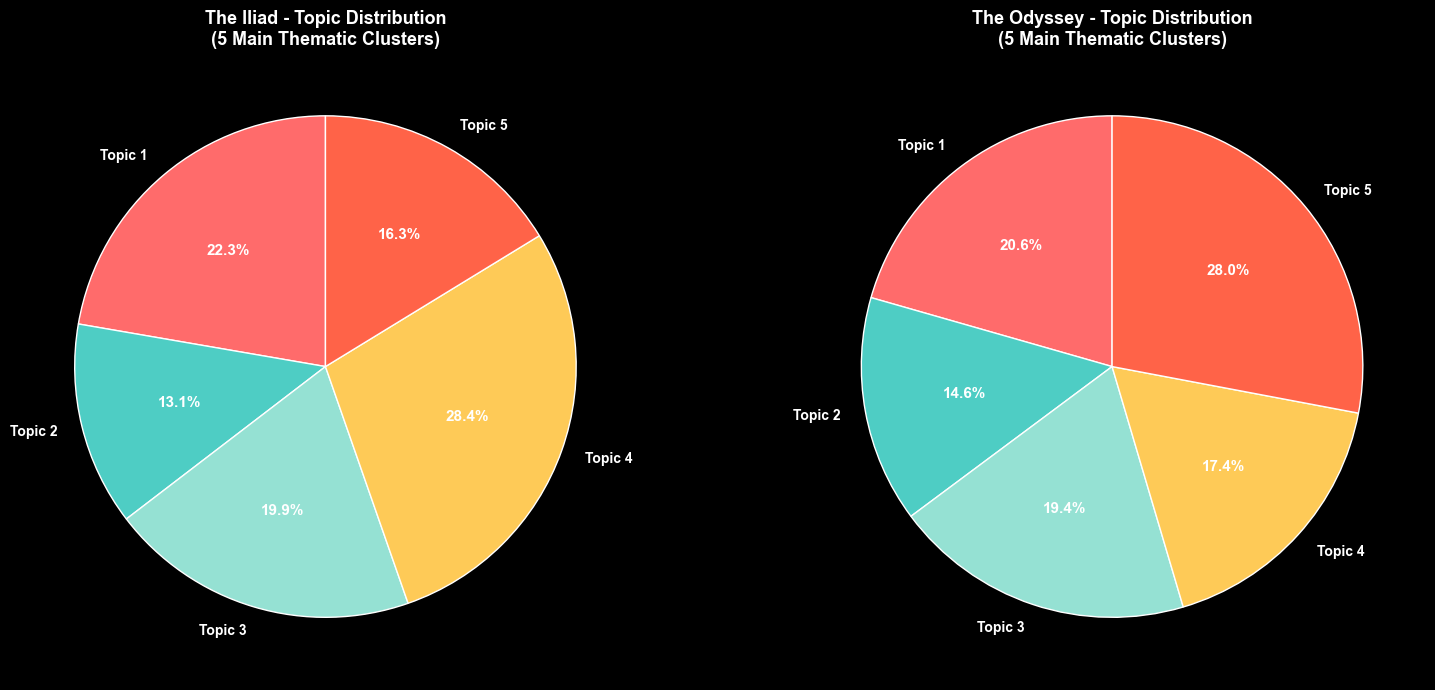


TOPIC DISTRIBUTION SUMMARY

The Iliad:
  Topic 1: 248 paragraphs (22.3%)
  Topic 2: 146 paragraphs (13.1%)
  Topic 3: 222 paragraphs (19.9%)
  Topic 4: 316 paragraphs (28.4%)
  Topic 5: 181 paragraphs (16.3%)

The Odyssey:
  Topic 1: 211 paragraphs (20.6%)
  Topic 2: 150 paragraphs (14.6%)
  Topic 3: 199 paragraphs (19.4%)
  Topic 4: 179 paragraphs (17.4%)
  Topic 5: 287 paragraphs (28.0%)

Note: Topics are identified by semantic similarity.
Manual inspection of sample paragraphs would reveal actual themes
(e.g., battle scenes, dialogue, divine intervention, travel, etc.)


In [95]:
from sklearn.cluster import KMeans

print("\n" + "="*70)
print("TOPIC DIVERSITY ANALYSIS")
print("="*70)

def cluster_paragraphs_by_topic(paragraphs: List[str], n_clusters: int = 5):
    """
    Use K-means clustering on paragraph embeddings to identify major themes.

    Each cluster represents a group of semantically similar paragraphs
    (e.g., battle scenes, dialogue, travel descriptions, etc.)

    Args:
        paragraphs: list of paragraph texts
        n_clusters: number of topic clusters to find

    Returns:
        Cluster labels for each paragraph
    """
    print(f"Clustering {len(paragraphs)} paragraphs into {n_clusters} topics...")

    # Get embeddings for all paragraphs (this may take a moment)
    para_embeddings = model.encode(paragraphs, show_progress_bar=True)

    # Use K-means to find clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(para_embeddings)

    print("✓ Clustering complete")
    return labels

# Cluster paragraphs into 5 main topics for each epic
print("\nAnalyzing The Iliad...")
iliad_clusters = cluster_paragraphs_by_topic(iliad_paras, n_clusters=5)

print("\nAnalyzing The Odyssey...")
odyssey_clusters = cluster_paragraphs_by_topic(odyssey_paras, n_clusters=5)

# Count paragraphs in each cluster
iliad_cluster_counts = [np.sum(iliad_clusters == i) for i in range(5)]
odyssey_cluster_counts = [np.sum(odyssey_clusters == i) for i in range(5)]

# Inspect topics by looking at sample paragraphs from each cluster
print("\n" + "="*70)
print("TOPIC INSPECTION - Sample paragraphs from each cluster")
print("="*70)

print("\n--- THE ILIAD TOPICS ---")
for i in range(5):
    print(f"\n{'='*70}")
    print(f"TOPIC {i+1} ({iliad_cluster_counts[i]} paragraphs, {iliad_cluster_counts[i]/len(iliad_paras)*100:.1f}%)")
    print(f"{'='*70}")
    # Get paragraphs in this cluster
    cluster_paras = [p for j, p in enumerate(iliad_paras) if iliad_clusters[j] == i]
    # Show first paragraph as example (truncated)
    sample = cluster_paras[0][:300] + "..." if len(cluster_paras[0]) > 300 else cluster_paras[0]
    print(f"Sample: {sample}\n")

print("\n--- THE ODYSSEY TOPICS ---")
for i in range(5):
    print(f"\n{'='*70}")
    print(f"TOPIC {i+1} ({odyssey_cluster_counts[i]} paragraphs, {odyssey_cluster_counts[i]/len(odyssey_paras)*100:.1f}%)")
    print(f"{'='*70}")
    # Get paragraphs in this cluster
    cluster_paras = [p for j, p in enumerate(odyssey_paras) if odyssey_clusters[j] == i]
    # Show first paragraph as example (truncated)
    sample = cluster_paras[0][:300] + "..." if len(cluster_paras[0]) > 300 else cluster_paras[0]
    print(f"Sample: {sample}\n")

print("\n" + "="*70)
print("MANUAL TOPIC LABELING")
print("="*70)
print("Based on the sample paragraphs above, manually assign labels:")
print("Examples: 'Battle Scenes', 'Dialogue', 'Divine Intervention',")
print("         'Journey/Travel', 'Character Descriptions', etc.")
print("\nUpdate the topic_labels list below with your labels:")

# MANUALLY UPDATE THESE LABELS based on what you see in the samples above
# After reading the sample paragraphs, replace these generic labels:
iliad_topic_labels = [
    'Topic 1',  # <-- Replace with actual theme (e.g., 'Battle Scenes')
    'Topic 2',  # <-- Replace with actual theme
    'Topic 3',  # <-- Replace with actual theme
    'Topic 4',  # <-- Replace with actual theme
    'Topic 5'   # <-- Replace with actual theme
]

odyssey_topic_labels = [
    'Topic 1',  # <-- Replace with actual theme (e.g., 'Sea Journey')
    'Topic 2',  # <-- Replace with actual theme
    'Topic 3',  # <-- Replace with actual theme
    'Topic 4',  # <-- Replace with actual theme
    'Topic 5'   # <-- Replace with actual theme
]

# Create pie charts with your custom labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

colors = ['#ff6b6b', '#4ecdc4', '#95e1d3', '#feca57', '#ff6348']

# The Iliad pie chart
wedges1, texts1, autotexts1 = ax1.pie(iliad_cluster_counts, labels=iliad_topic_labels,
                                        autopct='%1.1f%%', colors=colors, startangle=90,
                                        textprops={'fontsize': 10, 'fontweight': 'bold'})
# Make percentage text more visible
for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_fontsize(11)
ax1.set_title('The Iliad - Topic Distribution\n(5 Main Thematic Clusters)',
              fontsize=13, fontweight='bold')

# The Odyssey pie chart
wedges2, texts2, autotexts2 = ax2.pie(odyssey_cluster_counts, labels=odyssey_topic_labels,
                                        autopct='%1.1f%%', colors=colors, startangle=90,
                                        textprops={'fontsize': 10, 'fontweight': 'bold'})
# Make percentage text more visible
for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontsize(11)
ax2.set_title('The Odyssey - Topic Distribution\n(5 Main Thematic Clusters)',
              fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig("../results/paragraph_topic_clustering.png", dpi=300, bbox_inches='tight')
print("\n✓ Saved: ../results/paragraph_topic_clustering.png")
plt.show()

print("\n" + "="*70)
print("TOPIC DISTRIBUTION SUMMARY")
print("="*70)
print("\nThe Iliad:")
for i, count in enumerate(iliad_cluster_counts):
    print(f"  Topic {i+1}: {count} paragraphs ({count/len(iliad_paras)*100:.1f}%)")

print("\nThe Odyssey:")
for i, count in enumerate(odyssey_cluster_counts):
    print(f"  Topic {i+1}: {count} paragraphs ({count/len(odyssey_paras)*100:.1f}%)")

print("\nNote: Topics are identified by semantic similarity.")
print("Manual inspection of sample paragraphs would reveal actual themes")
print("(e.g., battle scenes, dialogue, divine intervention, travel, etc.)")



3D VISUALIZATION OF PARAGRAPH EMBEDDINGS
Encoding paragraphs for 3D visualization...


Batches: 100%|██████████| 16/16 [00:01<00:00, 12.60it/s]


Reducing dimensions to 3D...
✓ Explained variance: 15.3%
✓ Saved: ../results/paragraph_3d_analysis.png


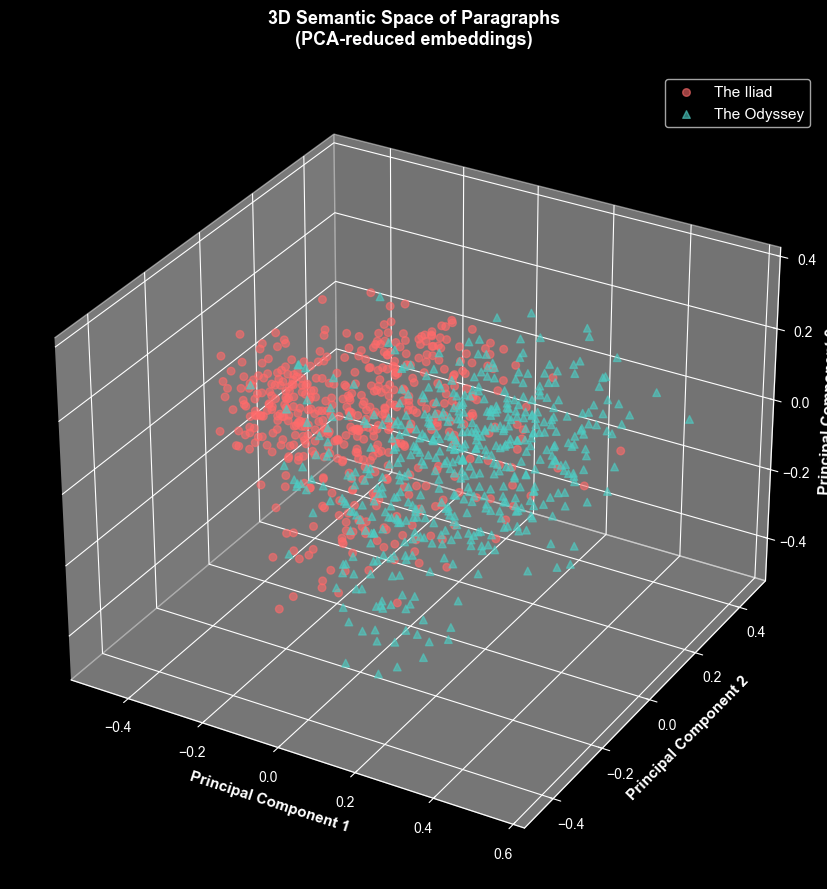


3D VISUALIZATION INTERPRETATION
What this shows:
- Each point represents one paragraph in semantic space
- Distance between points = semantic similarity
- Close points = similar topics/themes
- Clusters reveal thematic groupings
- Red circles = Iliad paragraphs
- Teal triangles = Odyssey paragraphs
- Overlap regions = shared themes between epics
- Separate regions = unique thematic content


In [96]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

print("\n" + "="*70)
print("3D VISUALIZATION OF PARAGRAPH EMBEDDINGS")
print("="*70)

# Get embeddings for both epics
print("Encoding paragraphs for 3D visualization...")
iliad_embeddings = model.encode(iliad_paras[:500], show_progress_bar=True)  # Limit for performance
odyssey_embeddings = model.encode(odyssey_paras[:500], show_progress_bar=True)

# Reduce high-dimensional embeddings to 3D using PCA
print("Reducing dimensions to 3D...")
all_embeddings = np.vstack([iliad_embeddings, odyssey_embeddings])
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(all_embeddings)

# Split back into Iliad and Odyssey
iliad_3d = embeddings_3d[:len(iliad_embeddings)]
odyssey_3d = embeddings_3d[len(iliad_embeddings):]

print(f"✓ Explained variance: {sum(pca.explained_variance_ratio_)*100:.1f}%")

# Create 3D scatter plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot both epics
ax.scatter(iliad_3d[:, 0], iliad_3d[:, 1], iliad_3d[:, 2],
           c='#ff6b6b', marker='o', s=30, alpha=0.6, label='The Iliad')
ax.scatter(odyssey_3d[:, 0], odyssey_3d[:, 1], odyssey_3d[:, 2],
           c='#4ecdc4', marker='^', s=30, alpha=0.6, label='The Odyssey')

ax.set_xlabel('Principal Component 1', fontsize=11, fontweight='bold')
ax.set_ylabel('Principal Component 2', fontsize=11, fontweight='bold')
ax.set_zlabel('Principal Component 3', fontsize=11, fontweight='bold')
ax.set_title('3D Semantic Space of Paragraphs\n(PCA-reduced embeddings)',
             fontsize=13, fontweight='bold', pad=20)
ax.legend(fontsize=11)

plt.tight_layout()
plt.savefig("../results/paragraph_3d_analysis.png", dpi=300, bbox_inches='tight')
print("✓ Saved: ../results/paragraph_3d_analysis.png")
plt.show()

print("\n" + "="*70)
print("3D VISUALIZATION INTERPRETATION")
print("="*70)
print("What this shows:")
print("- Each point represents one paragraph in semantic space")
print("- Distance between points = semantic similarity")
print("- Close points = similar topics/themes")
print("- Clusters reveal thematic groupings")
print("- Red circles = Iliad paragraphs")
print("- Teal triangles = Odyssey paragraphs")
print("- Overlap regions = shared themes between epics")
print("- Separate regions = unique thematic content")


SEMANTIC SIMILARITY HEATMAP - First Paragraph of Each Book
The Iliad: Extracted 24 first paragraphs (one per book)
The Odyssey: Extracted 24 first paragraphs (one per book)

Encoding first paragraphs...


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.87it/s]



✓ Saved: ../results/book_opening_similarity_heatmaps.png


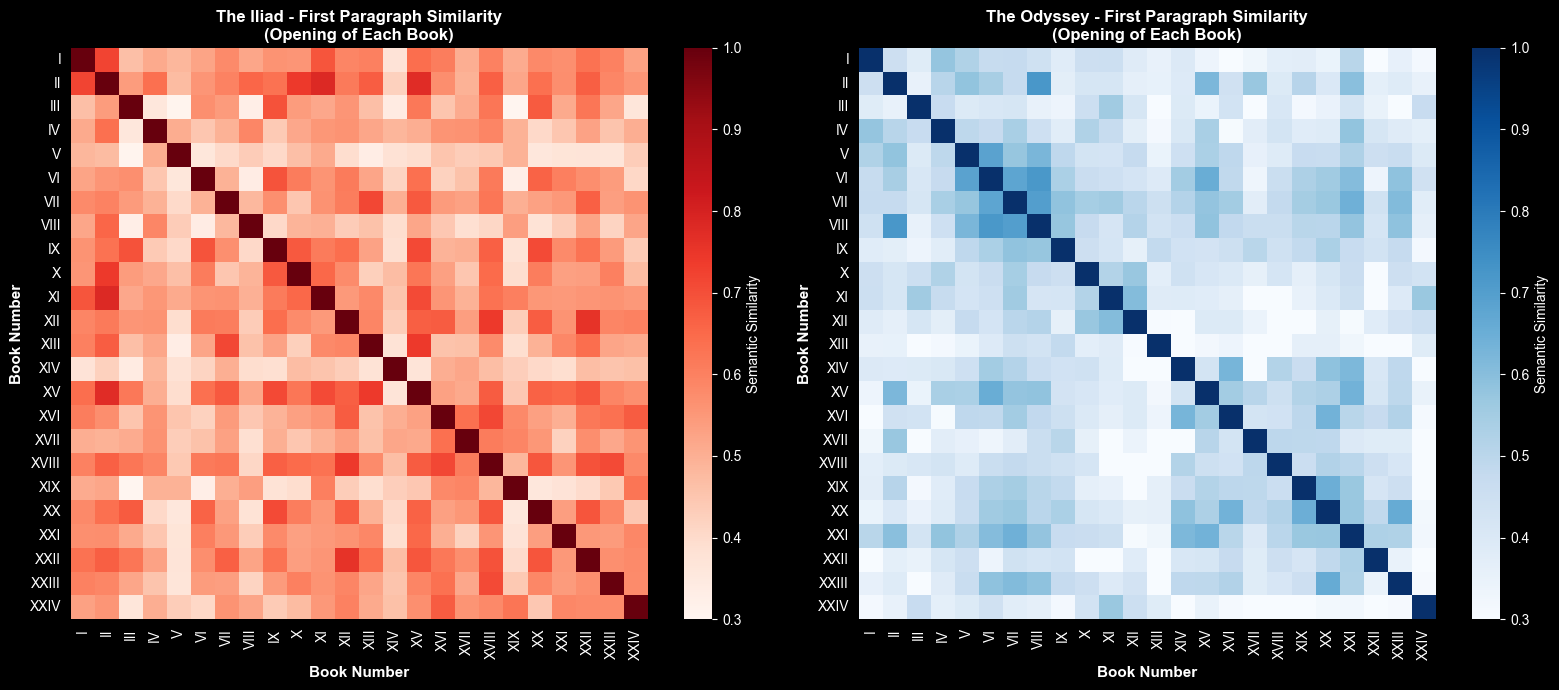


INTERPRETATION
- Diagonal = perfect similarity (each book to itself)
- Bright red/blue blocks = books with similar opening themes
- Dark regions = books that open very differently
- This shows thematic consistency across book introductions


In [97]:
from scipy.spatial.distance import cosine
import seaborn as sns

print("\n" + "="*70)
print("SEMANTIC SIMILARITY HEATMAP - First Paragraph of Each Book")
print("="*70)

def get_first_paragraph_per_book(text: str, epic_name: str) -> List[str]:
    """Extract the first paragraph from each of the 24 books."""

    # Split into books (same logic as before)
    if epic_name == "The Iliad":
        book_pattern = r'BOOK\s+([IVXLCDM]+)'
    else:  # Odyssey
        book_pattern = r'BOOK\s+([IVXLCDM]+)'

    book_splits = list(re.finditer(book_pattern, text))

    first_paragraphs = []

    for i in range(len(book_splits)):
        # Get text for this book
        start = book_splits[i].end()
        end = book_splits[i + 1].start() if i + 1 < len(book_splits) else len(text)
        book_text = text[start:end]

        # Get first paragraph from this book
        book_paras = split_into_paragraphs(book_text, min_words=10)
        if book_paras:
            first_paragraphs.append(book_paras[0])
        else:
            # Fallback if no valid paragraph found
            first_paragraphs.append(book_text[:500].strip())

    print(f"{epic_name}: Extracted {len(first_paragraphs)} first paragraphs (one per book)")
    return first_paragraphs[:24]  # Ensure we have exactly 24

# Extract first paragraphs
iliad_first_paras = get_first_paragraph_per_book(iliad_text, "The Iliad")
odyssey_first_paras = get_first_paragraph_per_book(odyssey_text, "The Odyssey")

# Get embeddings
print("\nEncoding first paragraphs...")
iliad_first_embeds = model.encode(iliad_first_paras, show_progress_bar=True)
odyssey_first_embeds = model.encode(odyssey_first_paras, show_progress_bar=True)

# Calculate similarity matrices (24x24 for each epic)
n_books = len(iliad_first_paras)
iliad_sim_matrix = np.zeros((n_books, n_books))
for i in range(n_books):
    for j in range(n_books):
        iliad_sim_matrix[i, j] = 1 - cosine(iliad_first_embeds[i], iliad_first_embeds[j])

odyssey_sim_matrix = np.zeros((n_books, n_books))
for i in range(n_books):
    for j in range(n_books):
        odyssey_sim_matrix[i, j] = 1 - cosine(odyssey_first_embeds[i], odyssey_first_embeds[j])

# Create heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Book labels (I, II, III, ... XXIV)
book_labels = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X',
               'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII', 'XVIII', 'XIX', 'XX',
               'XXI', 'XXII', 'XXIII', 'XXIV']

sns.heatmap(iliad_sim_matrix, annot=False, cmap='Reds',
            cbar_kws={'label': 'Semantic Similarity'},
            ax=ax1, vmin=0.3, vmax=1.0,
            xticklabels=book_labels, yticklabels=book_labels)
ax1.set_title('The Iliad - First Paragraph Similarity\n(Opening of Each Book)',
              fontsize=12, fontweight='bold')
ax1.set_xlabel('Book Number', fontsize=11, fontweight='bold')
ax1.set_ylabel('Book Number', fontsize=11, fontweight='bold')

sns.heatmap(odyssey_sim_matrix, annot=False, cmap='Blues',
            cbar_kws={'label': 'Semantic Similarity'},
            ax=ax2, vmin=0.3, vmax=1.0,
            xticklabels=book_labels, yticklabels=book_labels)
ax2.set_title('The Odyssey - First Paragraph Similarity\n(Opening of Each Book)',
              fontsize=12, fontweight='bold')
ax2.set_xlabel('Book Number', fontsize=11, fontweight='bold')
ax2.set_ylabel('Book Number', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig("../results/book_opening_similarity_heatmaps.png", dpi=300, bbox_inches='tight')
print("\n✓ Saved: ../results/book_opening_similarity_heatmaps.png")
plt.show()

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("- Diagonal = perfect similarity (each book to itself)")
print("- Bright red/blue blocks = books with similar opening themes")
print("- Dark regions = books that open very differently")
print("- This shows thematic consistency across book introductions")


NARRATIVE PROGRESSION ANALYSIS
Tracking how Homer's style evolves from beginning to end

The Iliad: Analyzing first 100 paragraphs
  Encoding paragraphs...
  ✓ Analysis complete

The Odyssey: Analyzing first 100 paragraphs
  Encoding paragraphs...
  ✓ Analysis complete

✓ Saved: ../results/narrative_progression_analysis.png


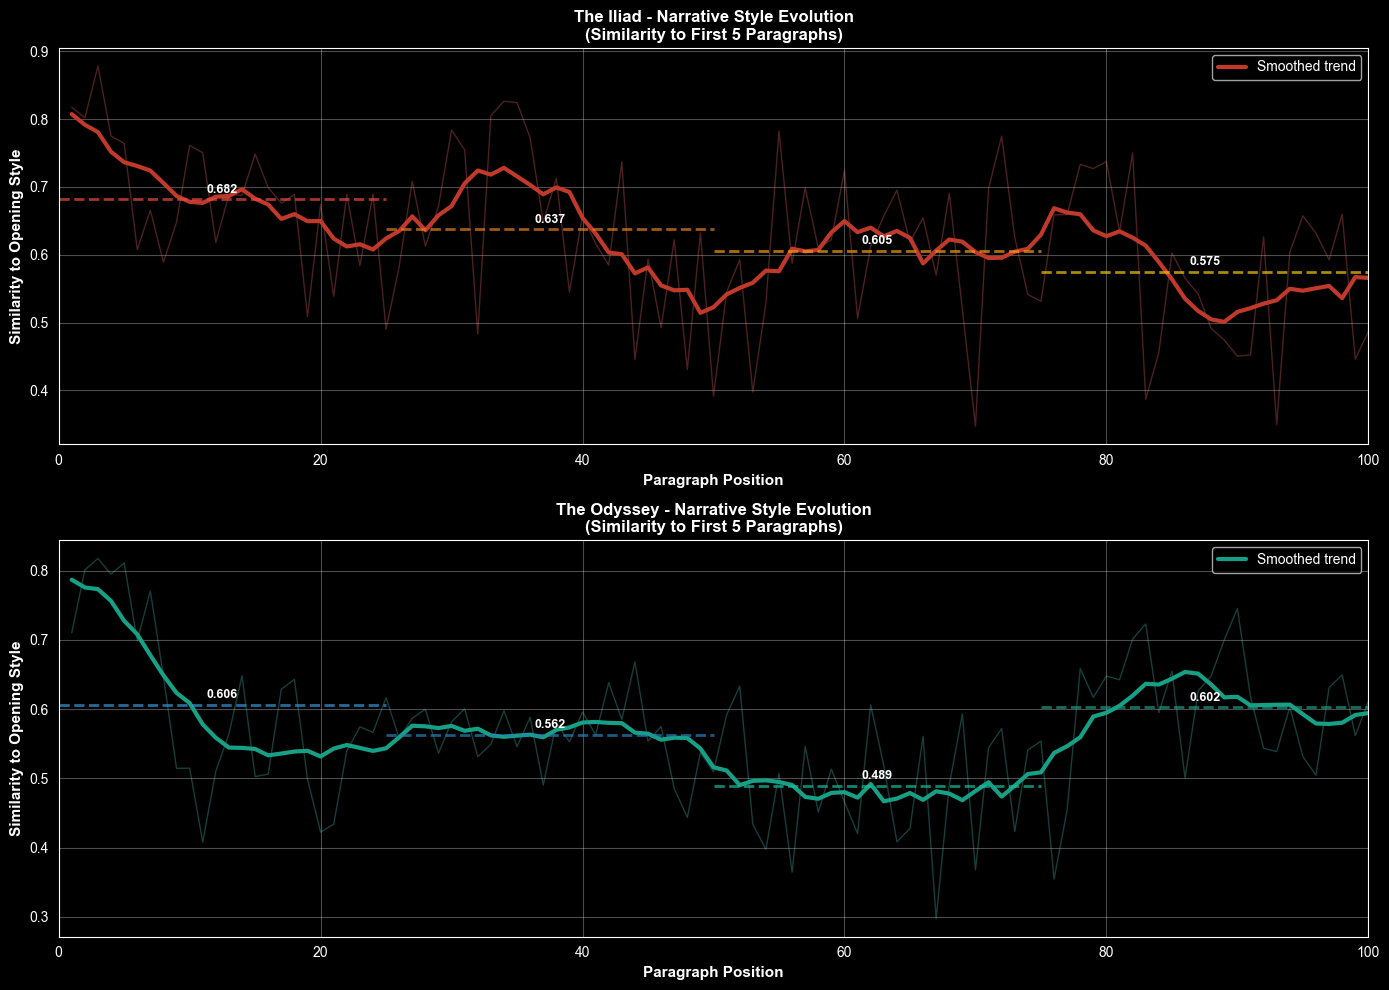


PROGRESSION SUMMARY

The Iliad - Section Averages:
  Early (1-25): 0.682
  Early-Mid (26-50): 0.637
  Late-Mid (51-75): 0.605
  Late (76-100): 0.575

  Style drift: 0.107
  Evolving style

The Odyssey - Section Averages:
  Early (1-25): 0.606
  Early-Mid (26-50): 0.562
  Late-Mid (51-75): 0.489
  Late (76-100): 0.602

  Style drift: 0.003
  Consistent style

INTERPRETATION GUIDE
What this graph shows:
- X-axis: paragraph position (1-100)
- Y-axis: semantic similarity to opening style
- Flat line = Homer maintains consistent style throughout
- Downward trend = style drifts away from opening
- Upward trend = style becomes more similar to opening

Possible patterns:
- Epic poetry often returns to similar themes cyclically
- Battle scenes may cluster (similar language)
- Dialogue sections may differ from narrative sections


In [98]:
print("\n" + "="*70)
print("NARRATIVE PROGRESSION ANALYSIS")
print("="*70)
print("Tracking how Homer's style evolves from beginning to end")
print("="*70)

def analyze_narrative_progression(paragraphs: List[str], epic_name: str, n_paragraphs: int = 100):
    """
    Analyze how narrative style changes from beginning to end.

    Strategy:
    1. Take first 100 paragraphs (manageable sample)
    2. Group into 4 sections: Early, Early-Mid, Late-Mid, Late
    3. Compare each section's similarity to the opening style
    4. Track if Homer's language drifts or stays consistent

    Args:
        paragraphs: full list of paragraphs
        epic_name: name for labeling
        n_paragraphs: number of paragraphs to analyze (default 100)

    Returns:
        Dictionary with section averages and individual scores
    """
    # Take first n_paragraphs
    sample_paras = paragraphs[:n_paragraphs]
    print(f"\n{epic_name}: Analyzing first {len(sample_paras)} paragraphs")

    # Encode all paragraphs
    print("  Encoding paragraphs...")
    embeddings = model.encode(sample_paras, show_progress_bar=False)

    # Reference: average of first 5 paragraphs (opening style)
    opening_embedding = embeddings[:5].mean(axis=0)

    # Calculate similarity of each paragraph to opening style
    similarities = []
    for emb in embeddings:
        sim = cosine_similarity(emb, opening_embedding)
        similarities.append(sim)

    # Group into 4 sections
    section_size = len(sample_paras) // 4
    sections = {
        'Early (1-25)': similarities[:section_size],
        'Early-Mid (26-50)': similarities[section_size:2*section_size],
        'Late-Mid (51-75)': similarities[2*section_size:3*section_size],
        'Late (76-100)': similarities[3*section_size:]
    }

    # Calculate average similarity per section
    section_averages = {name: np.mean(sims) for name, sims in sections.items()}

    print(f"  ✓ Analysis complete")

    return {
        'all_similarities': similarities,
        'section_averages': section_averages,
        'positions': list(range(1, len(sample_paras) + 1))
    }

# Analyze both epics
iliad_progression = analyze_narrative_progression(iliad_paras, "The Iliad")
odyssey_progression = analyze_narrative_progression(odyssey_paras, "The Odyssey")

# Create line graph showing progression
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# The Iliad progression
ax1.plot(iliad_progression['positions'], iliad_progression['all_similarities'],
         color='#ff6b6b', alpha=0.3, linewidth=1)
# Add smoothed trend line
from scipy.ndimage import uniform_filter1d
smoothed_iliad = uniform_filter1d(iliad_progression['all_similarities'], size=10)
ax1.plot(iliad_progression['positions'], smoothed_iliad,
         color='#c0392b', linewidth=3, label='Smoothed trend')

# Add section boundaries and averages
section_boundaries = [0, 25, 50, 75, 100]
section_names = list(iliad_progression['section_averages'].keys())
section_colors = ['#e74c3c', '#e67e22', '#f39c12', '#f1c40f']

for i, (name, avg) in enumerate(iliad_progression['section_averages'].items()):
    start = section_boundaries[i]
    end = section_boundaries[i + 1]
    ax1.axhline(y=avg, xmin=start/100, xmax=end/100,
                color=section_colors[i], linestyle='--', linewidth=2, alpha=0.7)
    ax1.text(start + (end-start)/2, avg + 0.01, f'{avg:.3f}',
             ha='center', fontsize=9, fontweight='bold')

ax1.set_xlabel('Paragraph Position', fontsize=11, fontweight='bold')
ax1.set_ylabel('Similarity to Opening Style', fontsize=11, fontweight='bold')
ax1.set_title('The Iliad - Narrative Style Evolution\n(Similarity to First 5 Paragraphs)',
              fontsize=12, fontweight='bold')
ax1.legend(loc='best', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, 100)

# The Odyssey progression
ax2.plot(odyssey_progression['positions'], odyssey_progression['all_similarities'],
         color='#4ecdc4', alpha=0.3, linewidth=1)
smoothed_odyssey = uniform_filter1d(odyssey_progression['all_similarities'], size=10)
ax2.plot(odyssey_progression['positions'], smoothed_odyssey,
         color='#16a085', linewidth=3, label='Smoothed trend')

section_colors_odyssey = ['#3498db', '#2980b9', '#1abc9c', '#16a085']

for i, (name, avg) in enumerate(odyssey_progression['section_averages'].items()):
    start = section_boundaries[i]
    end = section_boundaries[i + 1]
    ax2.axhline(y=avg, xmin=start/100, xmax=end/100,
                color=section_colors_odyssey[i], linestyle='--', linewidth=2, alpha=0.7)
    ax2.text(start + (end-start)/2, avg + 0.01, f'{avg:.3f}',
             ha='center', fontsize=9, fontweight='bold')

ax2.set_xlabel('Paragraph Position', fontsize=11, fontweight='bold')
ax2.set_ylabel('Similarity to Opening Style', fontsize=11, fontweight='bold')
ax2.set_title('The Odyssey - Narrative Style Evolution\n(Similarity to First 5 Paragraphs)',
              fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(0, 100)

plt.tight_layout()
plt.savefig("../results/narrative_progression_analysis.png", dpi=300, bbox_inches='tight')
print("\n✓ Saved: ../results/narrative_progression_analysis.png")
plt.show()

# Print summary statistics
print("\n" + "="*70)
print("PROGRESSION SUMMARY")
print("="*70)

print("\nThe Iliad - Section Averages:")
for section, avg in iliad_progression['section_averages'].items():
    print(f"  {section}: {avg:.3f}")

drift_iliad = iliad_progression['section_averages']['Early (1-25)'] - \
              iliad_progression['section_averages']['Late (76-100)']
print(f"\n  Style drift: {drift_iliad:.3f}")
print(f"  {'Consistent style' if abs(drift_iliad) < 0.05 else 'Evolving style'}")

print("\nThe Odyssey - Section Averages:")
for section, avg in odyssey_progression['section_averages'].items():
    print(f"  {section}: {avg:.3f}")

drift_odyssey = odyssey_progression['section_averages']['Early (1-25)'] - \
                odyssey_progression['section_averages']['Late (76-100)']
print(f"\n  Style drift: {drift_odyssey:.3f}")
print(f"  {'Consistent style' if abs(drift_odyssey) < 0.05 else 'Evolving style'}")

print("\n" + "="*70)
print("INTERPRETATION GUIDE")
print("="*70)
print("What this graph shows:")
print("- X-axis: paragraph position (1-100)")
print("- Y-axis: semantic similarity to opening style")
print("- Flat line = Homer maintains consistent style throughout")
print("- Downward trend = style drifts away from opening")
print("- Upward trend = style becomes more similar to opening")
print("\nPossible patterns:")
print("- Epic poetry often returns to similar themes cyclically")
print("- Battle scenes may cluster (similar language)")
print("- Dialogue sections may differ from narrative sections")

## Memory Cleanup

If you're running low on memory, run this cell to free up RAM by deleting large variables and clearing the model cache.

In [99]:
# If you're running low on memory, uncomment and run this section

# import gc
#
# # Delete large variables to free memory
# del iliad_text, odyssey_text
# del iliad_paras, odyssey_paras
# del iliad_scores, iliad_lengths, odyssey_scores, odyssey_lengths
#
# # Clear matplotlib figures
# plt.close('all')
#
# # Unload the model from memory
# del model
#
# # Force garbage collection
# gc.collect()
#
# print("Memory cleaned! Large variables deleted and garbage collected.")